In [86]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from pmdarima import AutoARIMA

In [87]:
df = pd.read_csv('../air-traffic-prediction/AirtrafficA4.csv')
df = df.dropna()
df['DATE'] = df['YEAR'].astype(str) + '-' + df['MONTH']
df['TOTAL DEPARTURES'] = df['TOTAL DEPARTURES'].str.replace(',', '').astype(float)
df['HOURS FLOWN'] = q = df['HOURS FLOWN'].str.replace(',', '').astype(float)
df['KILOMETRE FLOWN'] = df['KILOMETRE FLOWN'].str.replace(',', '').astype(float)
df['PASSENGERS CARRIED'] = df['PASSENGERS CARRIED'].str.replace(',', '').astype(float)
df['AVAILABLE SEAT KILOMETRE (IN THOUSAND)'] = df['AVAILABLE SEAT KILOMETRE (IN THOUSAND)'].str.replace(',', '').astype(float)
df[' FREIGHT CARRIED (IN TONNE)'] = df[' FREIGHT CARRIED (IN TONNE)'].str.replace(',', '').astype(float)
df['MAIL CARRIED (IN TONNE)'] = df['MAIL CARRIED (IN TONNE)'].str.replace(',', '').astype(float)
df.rename(columns={' FREIGHT CARRIED (IN TONNE)': 'FREIGHT CARRIED (IN TONNE)'}, inplace=True)

df['MONTH'] = df['MONTH'].str.strip()
df['MONTH'] = df['MONTH'].map({'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUNE': 6, 'JULY': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12})

#sorting df on the basis of year
df = df.sort_values(by=['YEAR', 'MONTH'])

df['SEASONAL_DIFF'] = df['PASSENGERS CARRIED'] - df['PASSENGERS CARRIED'].shift(12)
df['SEASONAL_DIFF'] = df['SEASONAL_DIFF'] - df['SEASONAL_DIFF'].shift(1)

df['log_PASSENGERS_CARRIED'] = np.log(df['PASSENGERS CARRIED'])
df['log_PASSENGERS_CARRIED'] = df['log_PASSENGERS_CARRIED'] - df['log_PASSENGERS_CARRIED'].shift(1)

df['sqrt_PASSENGERS_CARRIED'] = np.sqrt(df['PASSENGERS CARRIED'])

In [88]:
# ARIMA model 
model = AutoARIMA(seasonal=True ,sp=12, trace=True)
# model = AutoARIMA(seasonal=True, m=12, trace=True, 
#                    order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))

# y = df['PASSENGERS CARRIED'].dropna()
# y = df['SEASONAL_DIFF'].dropna()
y = df['log_PASSENGERS_CARRIED'].dropna()
# y = df['sqrt_PASSENGERS_CARRIED'].dropna()

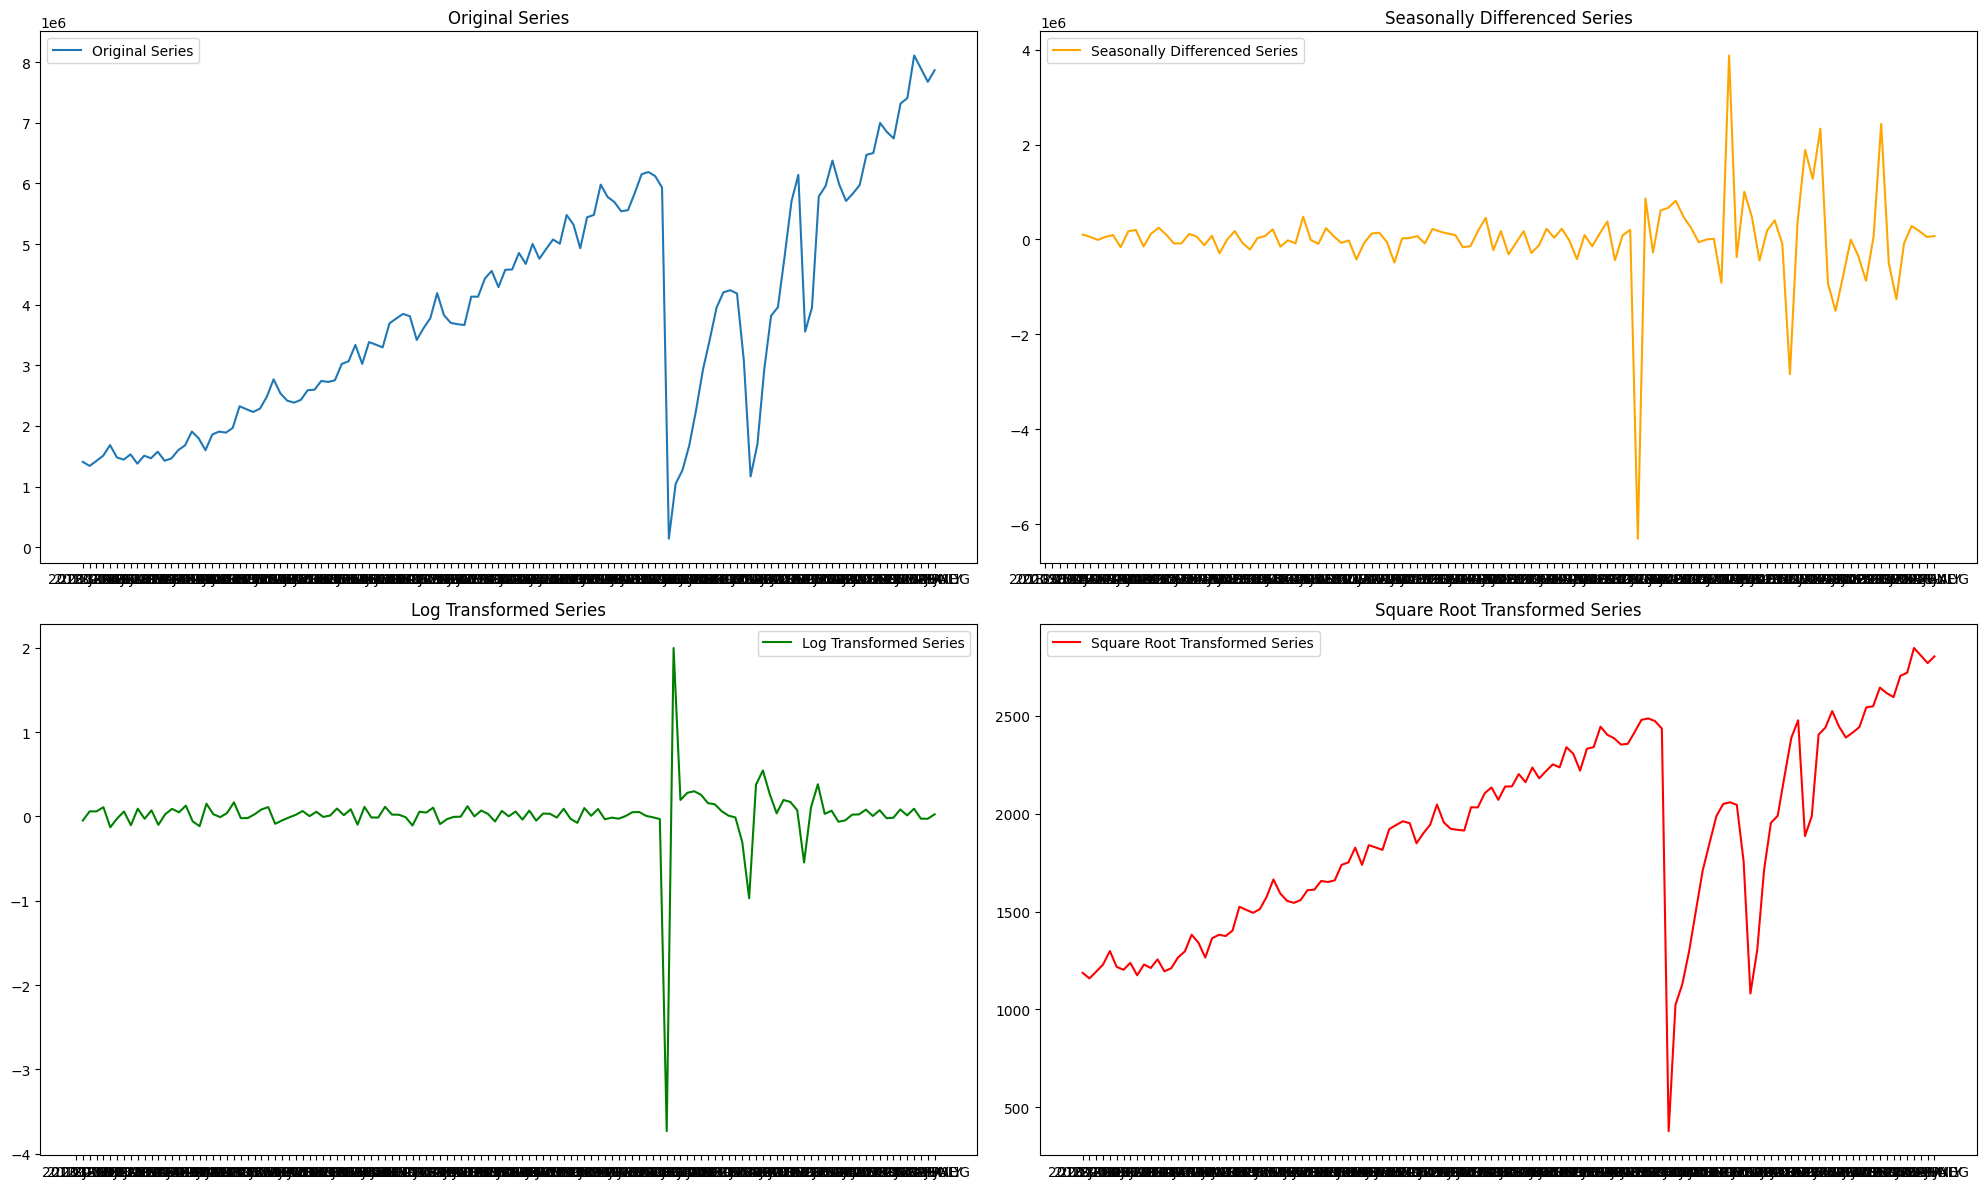

In [89]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

axs[0,0].plot(df['DATE'], df['PASSENGERS CARRIED'], label='Original Series')
axs[0,0].set_title('Original Series')
axs[0,0].legend()

axs[0,1].plot(df['DATE'], df['SEASONAL_DIFF'], label='Seasonally Differenced Series', color='orange')
axs[0,1].set_title('Seasonally Differenced Series')
axs[0,1].legend()

axs[1,0].plot(df['DATE'], df['log_PASSENGERS_CARRIED'], label='Log Transformed Series', color='green')
axs[1,0].set_title('Log Transformed Series')
axs[1,0].legend()

axs[1,1].plot(df['DATE'], df['sqrt_PASSENGERS_CARRIED'], label='Square Root Transformed Series', color='red')
axs[1,1].set_title('Square Root Transformed Series')
axs[1,1].legend()

plt.tight_layout()
plt.show()


In [90]:
model.fit(y)
forecast_steps = 12
y_pred_diff = model.predict(forecast_steps)

y_pred = np.exp(y_pred_diff)
last_value = df['PASSENGERS CARRIED'].iloc[-1]
y_pred = y_pred * last_value

forecast_index = pd.period_range(start='2023-09', periods=forecast_steps, freq='M')
forecast_dates = [date.strftime('%Y %b').upper() for date in forecast_index]

forecast_df = pd.DataFrame({
    'YEAR_MONTH': forecast_dates,
    'PASSENGERS CARRIED': y_pred
})

# print("YEAR_MONTH,PASSENGERS CARRIED")
# for _, row in forecast_df.iterrows():
#     print(f"{row['YEAR_MONTH']},{row['PASSENGERS CARRIED']}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=115.875, Time=1.68 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=133.910, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=123.253, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=118.684, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=132.053, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=113.463, Time=0.37 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=117.138, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=122.622, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=113.633, Time=0.18 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 7.290 seconds


In [91]:
forecast_df.to_csv('forecast.csv', index=False)
forecast_df

,YEAR_MONTH,PASSENGERS CARRIED
125,2023 SEP,7.758215e+06
126,2023 OCT,7.873696e+06
127,2023 NOV,7.927465e+06
128,2023 DEC,7.952356e+06
129,2024 JAN,7.963847e+06
130,2024 FEB,7.969146e+06
131,2024 MAR,7.971588e+06
132,2024 APR,7.972713e+06
133,2024 MAY,7.973231e+06
134,2024 JUN,7.973470e+06


### Part(b) 
Use an LLM to generate predictions see section 3 of LLMTIME for some ideas on
tokenisation of input, handling null values. Report only your best working prompting strategy
and their evaluations.[You are not expected to train/finetune an LLM nor use multimodal LLM
i.e you input pdf or screenshot, your input to the LLM should be PROMPT + string generated
from timeseries dataframe ideally by a script]

In [93]:
import pandas as pd
from prophet import Prophet

# Load and clean the dataset
df = pd.read_csv('../air-traffic-prediction/AirtrafficA4.csv')
df = df.dropna()

# Map month names to numbers for easier date handling
month_map = {'JAN': '01', 'FEB': '02', 'MAR': '03', 'APR': '04', 'MAY': '05', 'JUNE': '06',
             'JULY': '07', 'AUG': '08', 'SEP': '09', 'OCT': '10', 'NOV': '11', 'DEC': '12'}
df['MONTH'] = df['MONTH'].str.strip().map(month_map)

# Create a date column in the format Prophet needs
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'], format='%Y-%m')
df['PASSENGERS CARRIED'] = df['PASSENGERS CARRIED'].str.replace(',', '').astype(float)

# Prepare data for Prophet model
df_prophet = df[['DATE', 'PASSENGERS CARRIED']].rename(columns={'DATE': 'ds', 'PASSENGERS CARRIED': 'y'})

# Re-initialize Prophet model with some adjustments
model = Prophet(
    seasonality_mode='additive',  # Try 'additive' mode instead of 'multiplicative'
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

# Reduce the number of iterations for optimization
model.fit(df_prophet, algorithm='LBFGS', iter=2000)

# Define forecast period for 12 months (Sep 2023 to Aug 2024)
future = model.make_future_dataframe(periods=12, freq='M')

# Generate predictions
forecast = model.predict(future)

# Filter forecast results for the required months
forecast = forecast[['ds', 'yhat']].tail(12)
forecast['ds'] = forecast['ds'].dt.strftime('%Y-%b').str.upper()
forecast.rename(columns={'ds': 'YEAR_MONTH', 'yhat': 'PASSENGERS CARRIED'}, inplace=True)

# Save to CSV and display
forecast.to_csv('forecast_prophet.csv', index=False)
forecast


16:00:08 - cmdstanpy - INFO - Chain [1] start processing
16:00:08 - cmdstanpy - INFO - Chain [1] done processing
16:00:08 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 
Optimization terminated abnormally. Falling back to Newton.
16:00:08 - cmdstanpy - INFO - Chain [1] start processing
16:00:08 - cmdstanpy - INFO - Chain [1] done processing
16:00:08 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 


RuntimeError: Error during optimization! Command 'C:\Users\abhij\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\stan_model\prophet_model.bin random seed=65214 data file=C:\Users\abhij\AppData\Local\Temp\tmpzvae3udg\dsp816af.json init=C:\Users\abhij\AppData\Local\Temp\tmpzvae3udg\u50dhxln.json output file=C:\Users\abhij\AppData\Local\Temp\tmpzvae3udg\prophet_modelv4kubnjl\prophet_model-20241028160008.csv method=optimize algorithm=newton iter=2000' failed: 